In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import time
%matplotlib inline

#train_final.csv - the training set of interactions
train_final = pd.read_csv('input/train_final.csv', delimiter = "\t");

#tracks_final.csv - supplementary information about the items
tracks_final = pd.read_csv('input/tracks_final.csv', delimiter = "\t");

#playlists_final.csv - supplementary information about the users
playlists_final = pd.read_csv('input/playlists_final.csv', delimiter = "\t");

#target_playlists.csv - the set of target playlists that will receive recommendations
target_playlists = pd.read_csv('input/target_playlists.csv');

#target_tracks.csv - the set of target items (tracks) to be recommended
target_tracks = pd.read_csv('input/target_tracks.csv');


In [6]:
#Algorithm still not as good as it should be. 
#
#Bug hunting: 
#    - Bad content tags? Yes, alNone was a tag. Removed but still not improved. 
#    - Bad URM. The URM was only trained with 50% of data. Now fixed, improved a lot. 
#    - 
#    - 
#    - 
#    - 
#    - 
#    

In [7]:
import time

In [8]:
This step is not needed yet, will make ratings worse! 

def get_relevant_tracks():
    #Now we want to remove some redundant stuff. 

    #We will remove all songs which are not occurring more than 10 times in train_final
    #Nevertheless, we still want to keep all tracks which are in the target tracks.  

    popularity = train_final.groupby(by="track_id").playlist_id.nunique().to_frame()

    #remove index name
    popularity.reset_index(level = 0, inplace = True)

    #Rename the columns
    popularity.columns = ['track_id','occurrences']

    #Remove all targeted tracks - TESTED, working as expected
    tracks_relevant = popularity[~popularity['track_id'].isin(target_tracks['track_id'])]

    #Remove tracks occurring less than 10 times
    tracks_relevant = tracks_relevant[tracks_relevant['occurrences'] > 4]

    #Add the targeteted tracks back again
    tracks_relevant = pd.concat([tracks_relevant, target_tracks])

    return(tracks_relevant)

    print("Removed %s redundant tracks which occured less than 10 times." %(tracks_final-tracks_relevant))

tracks_relevant = get_relevant_tracks()

#Remove irrelevant tracks from train_final and tracks_final
train_final = train_final[train_final['track_id'].isin(tracks_relevant['track_id'])]

print("Train_final now contains %s interactions. " %(train_final.shape[0]))

tracks_final = tracks_final[tracks_final['track_id'].isin(tracks_relevant['track_id'])]

print("Tracks_final now contains %s tracks. "%(tracks_final.shape[0]))

SyntaxError: invalid syntax (<ipython-input-8-2a1f90dcda5f>, line 1)

In [9]:
#Now lets take a look at the tags.
tracks_final.head()

,track_id,artist_id,duration,playcount,album,tags
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]"
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]"
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]"
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]"
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]"


In [10]:
### Translating all content ids into indexes.

#We need to create buckets for the playcount and duration. 
#Lets create buckets and a help function for the duration. 

n_duration_buckets = 3
def duration_to_bucket(duration, alternative = 2):
    if (alternative == 1):
        n_duration_buckets = 8
        if duration <= 0:
            print("Null duration reached bucket function. ")
            return None
        elif duration < 90000: #not a song
            return 1
        elif duration < 140000: #short song
            return 2
        elif duration < 220000: #radio song
            return 3
        elif duration < 340000: #normal song
            return 4
        elif duration < 480000: #long song
            return 5
        elif duration < 720000: #really long
            return 6
        elif duration < 1200000: #super long
            return 7
        elif duration >= 1200000: #mixtape/compilation
            return 8
    elif(alternative == 2):
        n_duration_buckets = 3
        if duration <= 0:
            print("Null duration reached bucket function. ")
            return None
        elif duration <= 150000: #very short
            return 1
        elif duration > 150000 and duration < 720000: #very long
            return 2
        elif duration >= 720000: #mixtape/compilation
            return 3
        else: 
            return 0
        

n_playcount_buckets = 7
def playcount_to_bucket(playcount):
    if playcount <= 0 or playcount is None:
        print("Null playcount reached bucket function. ")
        return None
    elif playcount < 254: #0,4 percentile not popular
        return 1
    elif playcount < 881: #0,6 perc: known
        return 2
    elif playcount < 1560: #0,7 popular
        return 3
    elif playcount < 2808: #0,8 very popular
        return 4
    elif playcount < 5900: #0,9 hits
        return 5
    elif playcount < 10494: #0,95 super hits
        return 6
    elif playcount >= 10494: # mega hits
        return 7


In [11]:
tracks_final['tags'].head()

content_to_index = {}
content_to_id = {}
content_counter = 0

#Lets translate the tags to indexes.
for row in tracks_final['tags']:
    tags = row.strip('[ ]').split(', ')
    for tag in tags:
        if len(tag) > 0: 
            tag = "t"+tag
            if not(tag in content_to_index):
                content_to_index[tag] = content_counter
                content_to_id[content_counter] = tag
                content_counter += 1;
                
#Lets translate album into indexes
albumcount = 0 # 27607
for album in tracks_final['album']:
    album = album.strip('[ ]')
    if album != None and album != "None" and len(album) > 0: #None should not be considered content
        album = "al"+album
        if album == "alNone":
            print(album)
        if not(album in content_to_index):
            content_to_index[album] = content_counter
            content_to_id[content_counter] = album
            content_counter += 1
            albumcount += 1

#Lets translate artist_id into indexes 
artistcount = 0 #17537
for artist in tracks_final['artist_id']:
    artist = str(artist)
    if artist != None and artist != "None" and len(artist) > 0: #None should not be considered content
        artist = "ar"+artist
        if not(artist in content_to_index):
            content_to_index[artist] = content_counter
            content_to_id[content_counter] = artist
            content_counter += 1
            artistcount += 1
        
"""
#Lets translate the duration buckets into indexes. 
for bucket in range(n_duration_buckets): 
    bucket = "d"+str(bucket+1)
    content_to_index[bucket] = content_counter
    content_to_id[content_counter] = bucket
    print("added %s" %(bucket))
    content_counter += 1

#Lets translate the playcount buckets into indexes. 
for playcount in range(n_playcount_buckets): 
    playcount = "p"+str(playcount+1)
    content_to_index[playcount] = content_counter
    content_to_id[content_counter] = playcount
    
    content_counter += 1


## Alternative 2: Just one content type per continous variable. 
#Fun thing to try: can I add all duration/playcounts in one col, normalizing from 0-1? 


content_to_index["duration"] = content_counter
content_to_id[content_counter] = "duration"
content_counter += 1

content_to_index["playcount"] = content_counter
content_to_id[content_counter] = "playcount"
content_counter += 1
"""

print(len(content_to_index))
print("%s albums. 27607 expected." %albumcount)
print("%s artists. 17537 expected." %artistcount)

77040
27604 albums. 27607 expected.
17536 artists. 17537 expected.


In [14]:
class cti(object): 
    def __init__(self): 
        self.track_counter = 32195
        self.target_counter = 0
        
    def create_track_index(self, track_id, target_tracks):
        if track_id in target_tracks.track_id.values:
            idx = self.target_counter
            self.target_counter += 1
        else: 
            idx = self.track_counter
            self.track_counter += 1

        return idx
cti = cti()

In [15]:
#If we translate each track_id to a track_index which will serve as matrix index, we can save a lot of time. 


#We need a way to get from track_id to index in O(1).
#Let's create a dictionary

track_to_id = {}
track_to_index = {}
track_ids = tracks_final['track_id']

counter = 0;
for track_id in tracks_final['track_id']:
    track_id = int(track_id)
    track_to_index[track_id] = cti.create_track_index(track_id, target_tracks)
    track_to_id[counter] = track_id
    counter += 1;
    
#and a way to get from playlist_id to index in O(1)


playlist_to_index = {}
playlist_to_id = {}
counter = 0; 
for playlist_id in playlists_final['playlist_id']:
    playlist_id = int(playlist_id)
    playlist_to_index[playlist_id] = counter
    playlist_to_id[counter] = playlist_id
    counter += 1;
    
print("We have {} playlists with {} unique tracks with {} unique content types. ".format(len(playlist_to_index), len(track_to_index), len(content_to_index)))

We have 57561 playlists with 100000 unique tracks with 77040 unique content types. 


In [8]:
#Now we can create an Item Content Matrix. 

#ICM_all = np.zeros((len(tracks_indexes), len(tags_indexes)), int)
#ICM_all = sps.coo_matrix((len(track_to_index), len(content_to_index)), int)
#print(ICM_all.shape)


In [16]:
tracks_final[:10]

,track_id,artist_id,duration,playcount,album,tags
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]"
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]"
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]"
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]"
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]"
5,2256817,144,218000,2.0,[9],"[54087, 109806, 189631, 49166, 116712]"
6,2561768,928,223000,249.0,[26],"[50764, 4425, 11056, 205245, 81223]"
7,474864,928,193000,73.0,[22],"[205245, 81223, 11056, 267, 3982]"
8,1378455,928,304000,73.0,[22],"[11056, 205245, 81223, 189631, 84597]"
9,1523190,928,206000,10.0,[22],"[205245, 11056, 81223, 4425, 189631]"


In [17]:
#So let's fill the ICM with our data.
import math


def build_ICM():
    
    no_interactions = train_final.shape[0]
    
    tracks_matrix = tracks_final.as_matrix()
    rows = np.zeros((no_interactions,), dtype = int)
    cols = np.zeros((no_interactions,), dtype = int)
    val = np.zeros((no_interactions,), dtype = int)
    #val[i] = value of row[i] col[i]
    #val = []
    counter = 0
    starttime = time.time()
    lasttime = starttime
    trackno = 0
    addedalbums = {} #for testing
    addedartists = {} # for testing
    for track in tracks_matrix: 
        track_id, artist_id, duration, playcount, album, tags = np.split(track, 6)

        #Get track index
        track_index = track_to_index[int(track_id[0])]

        
        #add artist
        
        artist_index = content_to_index["ar"+str(artist_id[0])]
        addedartists[artist_index] = 1
        
        rows[counter] = track_index
        cols[counter] = artist_index
        val[counter] = 1
        counter += 1

        #add album
        album = album[0].strip("[ ]")

        if album != None and len(album) > 0 and not album == "None":
            album_index = content_to_index["al"+album]
            addedalbums[album_index] = 1 #testing
            
            rows[counter] = track_index
            cols[counter] = album_index
            val[counter] = 1
            counter += 1

        #add tags
        tags = tags[0].strip('[ ]').split(', ')

        for tag in tags: 
            if len(tag) > 0:
                tag = "t"+tag
                tag_index = content_to_index[tag]

                rows[counter] = track_index
                cols[counter] = tag_index
                val[counter] = 1
                
                counter+=1
        """
        ## ALT 1: Continuous variables in different content types. 
        
        #add duration
        duration = int(duration)
        if duration > 0:
            duration_bucket = duration_to_bucket(duration)
            if duration_bucket > 0:   
                duration_index = content_to_index["d"+str(duration_bucket)]

                rows[counter] = track_index
                cols[counter] = duration_index

                counter+=1
        
        #add playcount
        if playcount is not None and playcount != "None" and not math.isnan(playcount):
            playcount = int(playcount)
            if playcount > 0: 
                playcount_bucket = playcount_to_bucket(playcount)
                playcount_index = content_to_index["p"+str(playcount_bucket)]

                rows[counter] = track_index
                cols[counter] = playcount_index
                counter+=1
        """
        
        """
        ## ALT 2: Continuous variables in one content type. 
        
        #add duration
        duration = int(duration)
        if duration > 0:
            duration_bucket = duration_to_bucket(duration)
            duration_index = content_to_index["duration"]

            rows[counter] = track_index
            cols[counter] = duration_index
            val[counter] = duration_bucket/n_duration_buckets
            
            counter+=1

        #add playcount
        if playcount is not None and playcount != "None" and not math.isnan(playcount):
            playcount = int(playcount)
            if playcount > 0: 
                playcount_bucket = playcount_to_bucket(playcount)
                playcount_index = content_to_index["playcount"]

                rows[counter] = track_index
                cols[counter] = playcount_index
                val[counter] = playcount_bucket/n_playcount_buckets

                
                counter+=1
        """
        if trackno%5000 == 0:
            print("Track %s of %s. %s s sec." %(trackno, tracks_matrix.shape[0], round(time.time()-starttime, 2)))  
        trackno += 1

    #Implicit ratings: all ratings are 1.             
    
    rows = rows[:counter]
    cols = cols[:counter]
    val = val[:counter]
    #val = np.ones(rows.shape, dtype = int)

    #Build ICM matrix. 
    ICM_all = sps.coo_matrix((val, (rows, cols)), dtype = int)
    
    print("Built ICM matrix with %s content values." %(val.shape[0]))
    
    print("%s albums. 27607 expected." %len(addedalbums))
    print("%s artists. 17537 expected." %len(addedartists))
    
    return ICM_all


#Build new ICM
ICM_all = build_ICM()
print("Done!")



#Get old ICM

Track 0 of 100000. 0.0 s sec.
Track 5000 of 100000. 0.1 s sec.
Track 10000 of 100000. 0.2 s sec.
Track 15000 of 100000. 0.31 s sec.
Track 20000 of 100000. 0.42 s sec.
Track 25000 of 100000. 0.54 s sec.
Track 30000 of 100000. 0.64 s sec.
Track 35000 of 100000. 0.75 s sec.
Track 40000 of 100000. 0.87 s sec.
Track 45000 of 100000. 0.97 s sec.
Track 50000 of 100000. 1.07 s sec.
Track 55000 of 100000. 1.18 s sec.
Track 60000 of 100000. 1.28 s sec.
Track 65000 of 100000. 1.39 s sec.
Track 70000 of 100000. 1.5 s sec.
Track 75000 of 100000. 1.61 s sec.
Track 80000 of 100000. 1.72 s sec.
Track 85000 of 100000. 1.82 s sec.
Track 90000 of 100000. 1.93 s sec.
Track 95000 of 100000. 2.05 s sec.
Built ICM matrix with 656745 content values.
27604 albums. 27607 expected.
17536 artists. 17537 expected.
Done!


/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


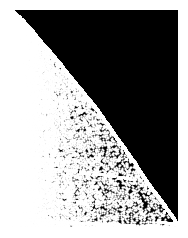

In [43]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

ICM_all = sps.load_npz("Saved Matrixes/ICM_perfect.npz")
ax = plot_coo_matrix(ICM_all)
ax.figure.show()

#ax = plot_coo_matrix(d.URM_train)
#ax.figure.show()

In [19]:
#Save the ICM

sps.save_npz("Saved Matrixes/ICM_all_coo", ICM_all)
print("Saved ICM!")

Saved ICM!


In [20]:
#Let's convert to csr. 
ICM_all = ICM_all.tocsr()
print("Converted")

Converted


In [21]:
target_tracks.head()

,track_id
0,1316175
1,3885714
2,3091270
3,226759
4,230596


In [22]:
def get_target_item_filter(indices):
    target_filter = np.zeros((indices), dtype = bool)
    for track in target_tracks.values:
        track_id = track[0]
        track_index = track_to_index[track_id]
        target_filter[track_index] = True
    print("Created filter preserving %s out of %s " %(np.count_nonzero(target_filter),target_filter.shape[0]))
    return target_filter


In [23]:
a = get_target_item_filter(tracks_final.shape[0])
print(a.shape)

Created filter preserving 32195 out of 100000 
(100000,)


In [24]:
a= np.array([1, 2, 3, 4])
f = [True, False, True, True]
a[f]

array([1, 3, 4])

In [25]:
a = sps.csr_matrix(np.random.rand(3,3))
a[0.5 >= a] = 0

#print(sps.csr_matrix(a.todense()))
print(a)

# Vi har en csr.

# om vi loopar igenom den och plockar bort noise, sedan skapar ny matrix. 


#print(sps.csr_matrix(a.toarray()))

  (0, 0)	0.0
  (0, 1)	0.53236836912
  (0, 2)	0.0
  (1, 0)	0.966417378606
  (1, 1)	0.778003864261
  (1, 2)	0.571272144388
  (2, 0)	0.0
  (2, 1)	0.906548600549
  (2, 2)	0.0


/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using <= is inefficient, try using > instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


In [26]:
def split_URM(k = 5): 
    
    playlistList = train_final['playlist_id'].values
    itemList = train_final['track_id'].values
    
    #Translate ids
    playlistList_translated = np.zeros(playlistList.shape)
    itemList_translated = np.zeros(itemList.shape)
    ratingList = np.ones((playlistList.shape), int)
    for i in range(train_final.shape[0]):
        playlistList_translated[i] = playlist_to_index[playlistList[i]]
        itemList_translated[i] = track_to_index[itemList[i]]
    
    ## Build URM_full. 
    URM_full = sps.coo_matrix((ratingList, (playlistList_translated, itemList_translated)))
    URM_full = URM_train.tocsr()
    
    ## Build URM_train & URM_test as zeros.
    URM_train = URM_full.copy()
    URM_test = sps.csr_matrix(np.zeros(URM_full.shape, dtype = int))

    # If the data should be splitted. 
    if k> 0:
        ## for each pl
        for i, row in enumerate(URM_full): 
            ## get indexes of tracks
            
            ## randomly remove k tracks
            indices = row.nonzero()[0]
            for j in range(2): 
                removed_index = int(np.floor(np.random.rand()*indices.shape[0]))
                removed_track = indices[removed_index]
                indices = np.delete(indices,removed_index) #Deletes the int on index removed_index
                
                #Removes the track from the row
                URM_train[i,removed_track] = 0
                URM_test[i,removed_track] = 1
                
    else: 
        return URM_full, URM_test
    
    
    
    
    

In [27]:
row = np.array([1, 0, 1, 0,1,0,1,0])


indices = row.nonzero()[0]
for j in range(2): 
    removed_index = int(np.floor(np.random.rand()*indices.shape[0]))
    removed_track = indices[removed_index]
    indices = np.delete(indices,removed_index) #Deletes the int on index removed_index
    row[removed_track] = 0

print(row)

[0 0 0 0 1 0 1 0]


In [28]:
# Get an owned_by_playlist_dictionary
playlist_owned_by = {}
for created_at, playlist_id, title, numtracks, duration, owner in playlists_final.as_matrix():
    if owner not in playlist_owned_by:
        playlist_owned_by[owner] = [playlist_id]
    else:
        playlist_owned_by[owner].append(playlist_id)
        
print(playlist_owned_by[40123])

[7541312, 5550682]


In [29]:
def build_URM(train_test_split = 0.80):
    #Builds urm 
    
    #train_test_split = 1
    
    numInteractions = train_final.shape[0]

    train_mask = np.random.choice(a = [True,False], size = numInteractions, p = [train_test_split, 1-train_test_split])
    
    playlistList = train_final['playlist_id'].values
    itemList = train_final['track_id'].values

    #Translate ids
    playlistList_translated = np.zeros(playlistList.shape)
    itemList_translated = np.zeros(itemList.shape)
    ratingList = np.ones((playlistList.shape), int)
    
    tru = train_mask[train_mask == True].shape[0]
    fal = (train_mask[train_mask == False].shape[0])
    
    print("True: %s. False: %s. Tot: %s" %(tru, fal, (tru+fal)))

    
    for i in range(train_final.shape[0]):
        playlistList_translated[i] = playlist_to_index[playlistList[i]]
        itemList_translated[i] = track_to_index[itemList[i]]
    #print("Translated ids to indexes.")
    
    
    #Build URM matrix. 
    URM_train = sps.coo_matrix((ratingList[train_mask], (playlistList_translated[train_mask], itemList_translated[train_mask])))
    URM_train = URM_train.tocsr()
    #print("Built URM_train with shape %s,%s" %(URM_train.shape[0],URM_train.shape[1]))
    
    if train_test_split < 1: 
        #Build URM_test
        test_mask = np.logical_not(train_mask)
        URM_test = sps.coo_matrix((ratingList[test_mask], (playlistList_translated[test_mask], itemList_translated[test_mask])))
        URM_test = URM_test.tocsr()
        print("Built URM_test")
        testsize = (test_mask[test_mask == True].shape[0])

    else: 
        URM_test = sps.csc_matrix((10, 10), dtype=np.int8)
        testsize = 0
    
    trainsize = train_mask[train_mask == True].shape[0]
    totsize = trainsize + testsize
    print("Total datapoints: %s. Expected: %s" %(totsize,numInteractions))

    
    print(URM_train.shape)
    print(URM_test.shape)
    
    return URM_train, URM_test

URM_train, URM_test = build_URM(0.8)

#Problem: The number of true/false values is not consistent.. Gives problems when testing. 

True: 832598. False: 207924. Tot: 1040522
Built URM_test
Total datapoints: 1040522. Expected: 1040522
(57560, 100000)
(57560, 100000)


/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


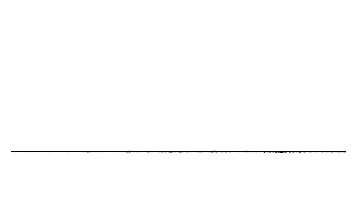

In [30]:
ax = plot_coo_matrix(URM_train)
ax.figure.show()

In [31]:
a = sps.coo_matrix(([1,1,1], ([0, 2, 2], [0, 1, 1])))
print(a)
print(a.todense())

  (0, 0)	1
  (2, 1)	1
  (2, 1)	1
[[1 0]
 [0 0]
 [0 2]]


In [32]:
## Let's take "secondary" ratings into account. 
#start_time = time.time()
## For owner in owners
#for count, owner in enumerate(playlist_owned_by):
#    playlists = playlist_owned_by[owner]
#    for i, playlist_id in enumerate(playlists):
#        for j, playlist_id in enumerate(playlists): 
#            if i != j: 
#                URM_train[i, :] += 0.3 * URM_train[j, :]
#    if count % 500 == 0 or count == 50:
#        print("owned %s of %s. %s sec." %(count, len(playlist_owned_by), time.time()-start_time))
#
## playlist 1 = playlist 1 + 0.3 * playlist 2
    

In [33]:
#Testing the URM builder.
print("URM_train contains %s interactions. Expected 1040422" %URM_train.nnz)
testcount = 0
traincount = 0
itr = 10000
for playlist_id, track_id in train_final[0:itr].values: 
    if (URM_train[playlist_to_index[playlist_id],track_to_index[track_id]]) > 0: 
        #print("Playlist %s with index %s and track %s with index %s was not in URM_train." %(playlist_id, playlist_to_index[playlist_id],track_id, track_to_index[track_id]))
        traincount += 1
    elif (URM_test[playlist_to_index[playlist_id],track_to_index[track_id]]) > 0:
        testcount += 1
        
print("Train: %s. Test: %s"%(traincount/itr, testcount/itr))
    

URM_train contains 832598 interactions. Expected 1040422
Train: 0.7934. Test: 0.2066


In [34]:
import time
class Recommender(object):
    def __init__(self, URM, target_items, item_ids, k=50, shrinkage=100, similarity='cosine', filter_method = 'content', topK = 100):
        self.dataset = URM
        self.target_items = target_items
        self.target_item_filter = get_target_item_filter(tracks_final.shape[0])
        self.item_ids = item_ids
        self.k = k
        self.shrinkage = shrinkage
        self.similarity_name = similarity
        self.filter_method = filter_method
        self.topK = topK
        self.ISM = None
        
        self.UIM = None
        
        if similarity == 'cosine':
            self.distance = Cosine(shrinkage=self.shrinkage)
        elif similarity == 'pearson':
            self.distance = Pearson(shrinkage=self.shrinkage)
        elif similarity == 'adj-cosine':
            self.distance = AdjustedCosine(shrinkage=self.shrinkage)
        else:
            raise NotImplementedError('Distance {} not implemented'.format(similarity))

    def __str__(self):
        return "Recommender(similarity={},k={},shrinkage={})".format(self.similarity_name, self.k, self.shrinkage)

    def fit_old(self, X, noise = 0.1):
        ## GET ISM MATRIX (I X I)
        cp = time.time()
        #Calculate cosine similarity    
        
        if self.ISM == None:
            self.ISM = self.distance.compute(X)
            print("Computed content based similarity matrix. %s " %(time.time()-cp))
        cp = time.time()
        
        
        ##GET URM (U X I)
        
        URM = self.dataset
        
        ## GET item_ids (1 x I)
        
        #self.item_ids
        
        ## FILTER item_ids INTO target_item_ids (1 x tI)
        
        self.target_item_ids = track_ids[self.target_item_filter]
        print(URM.nnz)
        print(ISM.nnz)
        
        ## FILTER TARGETED TRACKS
        #Maybe this is not working as expected - are we filtering the right tracks? 
        
        # Convert to csc before.. 
        ISM = check_matrix(ISM, 'csc')
        ISM = ISM[:,32195]
        print("Filtered targeted tracks in ISM. %s " %(time.time()-cp))
        cp = time.time()
        
        #self.ISM = sps.csr_matrix(self.ISM)
        
        cp = time.time()  
        print(URM.nnz)
        #ISM = sps.csr_matrix(ISM)
        print(ISM.nnz)
        
        ## CONVERT URM TO CSR
        URM = check_matrix(URM, 'csr')
        print("Checked URM csr %s " %(time.time()-cp))
        cp = time.time()
        
        ##Print dimension
        print(URM.shape)
        print(ISM.shape)
        
        ## MULTIPLY URM (U x I) * ISM (I x I)
        UIM = URM.dot(ISM)
        print("Computed URM * ISM %s " %(time.time()-cp))
        cp = time.time()
        

        
        ## MAKE NOT SPARSE
        #UIM_dense = UIM.todense()
        
        ## FILTER UIM into (U x tI) (not needed since I already filtered!)
        #UIM_dense = UIM_dense[:,self.target_item_filter]
        
        ## THIS IS OUR FITTED MODEL
        self.UIM = UIM
        
        return self.UIM
  
    def fit_new(self, X, noise = 0.1, CF_ratio = 0.5):
        ## GET ISM MATRIX (I X I)
        cp = time.time()
        #Calculate cosine similarity
        print("Using %s filtering with TopK = %s to compute distance." %(self.filter_method, self.topK))
        
        cosine_cython = Cosine_Similarity(URM_train, TopK=self.topK)
        ISM_cf = cosine_cython.compute_similarity()
        
        print("Computed collaborative similarity matrix. %s " %(time.time()-cp))
        cp = time.time()
        
        ISM_cont = self.distance.compute(X)
        print("Computed content based similarity matrix. %s " %(time.time()-cp))
        cp = time.time()
        
        w1 = CF_ratio
        w2 = 1-CF_ratio
        ISM = w1 * ISM_cf + w2 * ISM_cont
        print("Combined similarity matrices with ratio %s. %s " %(CF_ratio, time.time()-cp))
        cp = time.time()
        
        ##GET URM (U X I)
        
        URM = self.dataset
        
        ## GET item_ids (1 x I)
        
        #self.item_ids
        
        ## FILTER item_ids INTO target_item_ids (1 x tI)
        
        self.target_item_ids = track_ids[self.target_item_filter]
        print(URM.nnz)
        print(ISM.nnz)
        
        ## FILTER TARGETED TRACKS
        #Maybe this is not working as expected - are we filtering the right tracks? 
        
        ISM = ISM[:,self.target_item_filter]
        print("Filtered targeted tracks in ISM. %s " %(time.time()-cp))
        cp = time.time()
        
        #self.ISM = sps.csr_matrix(self.ISM)
        
        cp = time.time()  
        print(URM.nnz)
        #ISM = sps.csr_matrix(ISM)
        print(ISM.nnz)
        
        ## CONVERT URM TO CSR
        URM = check_matrix(URM, 'csr')
        print("Checked URM csr %s " %(time.time()-cp))
        cp = time.time()
        
        ##Print dimension
        print(URM.shape)
        print(ISM.shape)
        
        ## MULTIPLY URM (U x I) * ISM (I x I)
        UIM = URM.dot(ISM)
        print("Computed URM * ISM %s " %(time.time()-cp))
        cp = time.time()
        

        
        ## MAKE NOT SPARSE
        #UIM_dense = UIM.todense()
        
        ## FILTER UIM into (U x tI) (not needed since I already filtered!)
        #UIM_dense = UIM_dense[:,self.target_item_filter]
        
        ## THIS IS OUR FITTED MODEL
        self.UIM = UIM
        
        return self.UIM

        
    def recommend_new(self, user_id, at = 5):
        ## GET USER_INDEX
        user_index = playlist_to_index[user_id]
        
        # Convert to np.array (why wasn't it before?!)
        self.target_item_ids = np.array(self.target_item_ids)
        
        ## GET ROW CORRESPONDING TO USER (1 x tI)
        user_weights = self.UIM[user_index,:].toarray()
             
        ## ARGSORT BASED ON AXIS = 0, GET [1,0:at]
        top_indexes = np.argsort(user_weights)#[-at:]
        top_k_indexes = top_indexes[0, -at:]

        ## Translate to indexes
        recommendations = self.target_item_ids[top_k_indexes]
        
        ## RETURN RECOMMENDATIONS
        return(recommendations)
    
    def recommend_dev(self, user_id, at = 5):
        print("Recommend %s items for user %s!" %(at, user_id))
        ## GET USER_INDEX
        user_index = playlist_to_index[user_id]
        
        # Convert to np.array (why wasn't it before?!)
        self.target_item_ids = np.array(self.target_item_ids)
        
        ## GET ROW CORRESPONDING TO USER (1 x tI)
        user_weights = self.UIM[user_index,:].toarray()
             
        ## ARGSORT BASED ON AXIS = 0, GET [1,0:at]
        top_indexes = np.argsort(user_weights)#[-at:]
        print(top_indexes.shape)
        top_k_indexes = top_indexes[0, -at:]
        print(top_k_indexes.shape)

        ## Translate to indexes
        recommendations = self.target_item_ids[top_k_indexes]
        
        ## RETURN RECOMMENDATIONS
        return(recommendations)
        
        
        

    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.dataset[user_id]
        print("User profile: %s" %(user_profile))
        scores = user_profile.dot(self.W_sparse).toarray().ravel()
        print("Scores: %s" %(scores))
        # rank items
        ranking = scores.argsort()[::-1]
        if exclude_seen:
            ranking = self._filter_seen(user_id, ranking)
        
        print("Ranking: %s" %(ranking))
        
        export = [0,0,0,0,0]
        for i in range(5):
            t_id = track_to_id[ranking[i]]
            export[i] = t_id
            
        return export
    def _filter_seen(self, user_id, ranking):
        user_profile = self.dataset[user_id]
        seen = user_profile.indices
        unseen_mask = np.in1d(ranking, seen, assume_unique=True, invert=True)
        return ranking[unseen_mask]

print("asd")

asd


In [35]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sps.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sps.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sps.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sps.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sps.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sps.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sps.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [36]:
import scipy
from sklearn.metrics.pairwise import cosine_similarity

class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)
        print("Converted to csc.")
        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        dist = X * X.T
        print("Computed")
        
        # zero out diagonal values
        dist = dist - sps.dia_matrix((dist.diagonal()[scipy.newaxis, :], [0]), shape=dist.shape)
        print("Removed diagonal")
        
        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        print("Multiplying again..")
        co_counts = X_ind * X_ind.T
        # remove the diagonal
        print("Removing diagonal again..")
        # co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        print("Applying shrinkage")
        cp = time.time()
        co_counts_shrink = co_counts.copy()
        print("one %s "%(time.time()-cp))
        cp = time.time()
        co_counts_shrink.data += self.shrinkage
        print("two %s "%(time.time()-cp))
        cp = time.time()
        co_counts.data /= co_counts_shrink.data
        print("three %s "%(time.time()-cp))
        cp = time.time()
        dist.data *= co_counts.data
        print("four %s "%(time.time()-cp))
        cp = time.time()
        return dist
    
    def remove_noise(self, X, noise):
        X = check_matrix(X, 'csc', dtype=np.float32)
        i = 0
        for row in X:
            r = row
            row[row > noise] = 1
            row[row <= noise] = 0

            X[i,:] = r[row]
            i += 1
        return X


In [37]:
def kkeep_k_largest(X, k):
    
    M = X.todense()
    for row in M: 
        top_k_idx = np.argsort(row)
        print(row)
        print(row[0,top_k_idx[0,-k]])
        
    

In [38]:
### Creating a Item-Item Similarity Matrix based on Collaborative Filtering. 
class CF(object): 
    def __init__(self):
        pass
    def Item_Similarity(self, URM, k = 100, shrinkage = 10):
        #Takes a URM (U x I), returns ISM (I x I)
        
        self.shrinkage = shrinkage
        
        # We explore the matrix column-wise
        URM = check_matrix(URM, 'csc')

        n_items = URM.shape[1]

        values = []
        rows = []
        cols = []

        start_time = time.time()
        processedItems = 0

        # Compute all similarities for each item using vectorization
        for itemIndex in range(n_items):

            processedItems += 1

            if processedItems % 100==0:

                itemPerSec = processedItems/(time.time()-start_time)

                print("Similarity item {}, {:.2f} item/sec, required time {:.2f} min".format(
                    processedItems, itemPerSec, n_items/itemPerSec/60))

            # All ratings for a given item
            item_ratings = URM[:,itemIndex]
            item_ratings = item_ratings.toarray().squeeze()
            #print(item_ratings)

            # Compute item similarities
            this_item_weights = URM.T.dot(item_ratings)
            
            #print(this_item_weights)

            # Sort indices and select TopK
            top_k_idx = np.argsort(this_item_weights) [-k:]

            # Incrementally build sparse matrix
            #print(top_k_idx)
            values.extend(this_item_weights[top_k_idx])
            rows.extend(np.arange(URM.shape[1])[top_k_idx])
            cols.extend(np.ones(k) * itemIndex)
          
            
        W_sparse = sps.csc_matrix((values, (rows, cols)),
                                shape=(n_items, n_items),
                                dtype=np.float32)
        
        # zero out diagonal values
        W_sparse = W_sparse - sps.dia_matrix((W_sparse.diagonal()[scipy.newaxis, :], [0]), shape=W_sparse.shape)
        print("Removed diagonal")
        
        W_sparse.data /= np.repeat(norm, col_nnz)
        print("Normalized")
        
        # and apply the shrinkage
        if shrinkage > 0:
            W_sparse = self.apply_shrinkage(URM, W_sparse)
            print("Applied shrinkage") 

        return W_sparse

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
        co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist


In [39]:
URM = np.matrix([[1, 0, 1, 0, 0, 1], [0, 0, 1, 0, 1, 1], [1, 0, 1, 0, 1, 0]])
print(URM)
cf = CF()
URM_sparse = sps.csc_matrix(URM, dtype = int)


ISM = cf.Item_Similarity(URM_sparse, k = 4, shrinkage = 0)
print(ISM.nnz)
print(ISM.todense())
print(ISM)


[[1 0 1 0 0 1]
 [0 0 1 0 1 1]
 [1 0 1 0 1 0]]
Removed diagonal


NameError: name 'norm' is not defined

In [40]:
#URM_train, URM_test = build_URM(0.8)

#cosine_cython = Cosine_Similarity(URM_train, TopK=50)

#start_time = time.time()

#ISM = cosine_cython.compute_similarity()

#print("Similarity computed in {:.2f} seconds".format(time.time()-start_time))
#print(ISM.shape)
#print(ISM.nnz)

<100000x77040 sparse matrix of type '<class 'numpy.int64'>'
	with 656726 stored elements in Compressed Sparse Row format>

In [42]:
### This is the main script ###


#1. Fitting the model. 

#If export is true, the recommendations will be written to file. 
#If false, evaluation method can be used. 

## PARAMS

export = True
filter_method = 'content'
topK = 100
shrinkage=0




if export:
    train_rate = 1
else:
    train_rate = 0.8
    
print("Running with train_rate %s" %(train_rate))

URM_train, URM_test = build_URM(train_rate)

import time
starttime = time.time()
rec = Recommender(URM=URM_train, 
                  target_items = target_tracks, 
                  item_ids = track_ids, 
                  shrinkage = shrinkage, 
                  filter_method = filter_method,
                  topK = topK)

ICM_all = sps.load_npz("Saved Matrixes/ICM_perfect.npz")
#print("Loaded ICM!")
#rec.ISM = sps.load_npz("Saved Matrixes/ISM_.npz")

#ax = plot_coo_matrix(ICM_all)
#ax.figure.show()

rec.fit_old(ICM_all)

print("Model fitted in %s seconds" %(time.time()-starttime))


Running with train_rate 1
True: 1040522. False: 0. Tot: 1040522
Total datapoints: 1040522. Expected: 1040522
(57560, 100000)
(10, 10)
Created filter preserving 32195 out of 100000 
Converted to csc.
Normalized
Computed
Removed diagonal
Computed content based similarity matrix. 93.13628005981445 
1040522


UnboundLocalError: local variable 'ISM' referenced before assignment

In [38]:
#2. Creating recommendations. 
zeros = np.zeros((target_playlists.size, 6), dtype = int)
recommendations = pd.DataFrame(zeros)
recommendations.columns = ['playlist_id', 1, 2, 3, 4, 5]

zeros2 = np.zeros((target_playlists.size, 5), dtype = int)
recommendations_wrong_order = pd.DataFrame(zeros2)

counter = 0
starttime = time.time()
for playlist_id in target_playlists['playlist_id']:

    if counter % 1000 == 0: 
        print ("%s out of 10000 playlists, %s sec." %(counter, time.time()-starttime))

    playlist_id_translated = playlist_to_index[int(playlist_id)]
    recommendations_wrong_order.iloc[counter, 0:5] = rec.recommend_new(playlist_id, 5)
    recommendations.iloc[counter, 0] = playlist_id
    counter += 1
recommendations.iloc[:,1:6] = recommendations_wrong_order.iloc[::-1] #.iloc[::-1] reverses the dataset. 
    
if export:
    filename = "recommendations_6/11_"
    np.savetxt("output/rec_new_ICM_shrink_0_ro.csv",recommendations, fmt = '%s,%s %s %s %s %s', header = "playlist_id,track_ids", newline = "\n")
    print("Saved to file ")

#print(recommendations)
print("Done")

0 out of 10000 playlists, 0.00023102760314941406 sec.
1000 out of 10000 playlists, 2.0612740516662598 sec.
2000 out of 10000 playlists, 4.073239803314209 sec.
3000 out of 10000 playlists, 6.147836923599243 sec.
4000 out of 10000 playlists, 8.366047143936157 sec.
5000 out of 10000 playlists, 10.66915488243103 sec.
6000 out of 10000 playlists, 12.844542026519775 sec.
7000 out of 10000 playlists, 14.909801959991455 sec.
8000 out of 10000 playlists, 17.097878217697144 sec.
9000 out of 10000 playlists, 19.266996145248413 sec.
Saved to file 
Done


,0,1,2,3,4
9999,2854352,3841976,646158,2280075,1208092
9998,3719307,1742150,1231806,157531,1218366
9997,1587449,1337673,2754855,2120528,1626372
9996,429203,3070164,3542206,3051566,3076030
9995,15150,2839248,1914261,2999383,1109472


In [ ]:
# 3. Want to evaluate? 
print(URM_test.shape)
print(URM_train.shape)


In [30]:
a = pd.DataFrame([4, 3, 2, 1, 0])
print(a)
print(a.iloc[::-1])

   0
0  4
1  3
2  2
3  1
4  0
   0
4  0
3  1
2  2
1  3
0  4


In [41]:
evaluate_algorithm(URM_test, recommendations)

Recommender performance is: Precision = 0.0355, Recall = 0.0309, MAP = 0.0218


In [138]:
# Does the recommender rec just targeted tracks? 
def test_all_rec_in_target(recommendations):
    tt = target_tracks.values
    recommendations = recommendations.as_matrix()
    notcount = 0
    count = 0
    for row in recommendations: 
        for item in row[1:6]: 
            count += 1
            if item in tt: 
                notcount += 1
                #print("Rec not in target! %s" %item)
    print("%s out of %s were in the target." %(notcount, count))
    
test_all_rec_in_target(recommendations)

50000 out of 50000 were in the target.


In [ ]:
## TESTING THE REC FUNCTION - SHOULD WORK
#Fitted in 172.8 seconds

rec_dev = Recommender(URM=URM_train, target_items = target_tracks, item_ids = track_ids, shrinkage=0.0)
rec_dev.UIM = rec.UIM
rec_dev.target_item_ids = rec.target_item_ids

zeros = np.zeros((1, 6), dtype = int)
recommendations = pd.DataFrame(zeros)
recommendations.columns = ['playlist_id', 1, 2, 3, 4, 5]
recommendations.iloc[counter, 1:6] = rec_dev.recommend_dev(playlist_to_id[30680], 5)
recommendations.iloc[counter, 0] = playlist_to_id[30680]

print(recommendations)



In [ ]:
import time
starttime = time.time()
rec = Recommender(URM=URM_train, shrinkage=0.0)
rec.fit(ICM_all)
print("Done in %s seconds" %(time.time()-starttime))

In [31]:
def ICM_add_IDF(ICM): 
    num_tot_items = ICM_all.shape[0]

    # let's count how many items have a certain feature
    items_per_feature = (ICM_all > 0).sum(axis=0)

    IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

    print(ICM_all.shape)
    print(IDF.shape)
    ICM_idf = sps.csr_matrix(ICM_all, dtype=np.float64)
    # compute the number of non-zeros in each col
    # NOTE: this works only if X is instance of sparse.csc_matrix
    col_nnz = np.diff(check_matrix(ICM_idf, 'csc').indptr)
    print(col_nnz.shape)
    print(ICM_idf.shape)
    print(IDF.shape)
    # then normalize the values in each col
    ICM_idf.data *= np.repeat(IDF, col_nnz)
    return ICM_idf

In [ ]:
rec_idf = BasicItemKNNRecommender(URM=URM_train, shrinkage=0.0, k=50)
rec_idf.fit(ICM_idf)

In [40]:
#Evaluation functions

def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

def evaluate_algorithm(URM_test, recommendations, at=5):
    
    starttime = time.time()
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0
    
    playlists = target_playlists['playlist_id']
    
    for i, playlist_id in enumerate(playlists):
        relevant_items = URM_test[playlist_to_index[playlist_id]].indices
        
        for j, item_id in enumerate(relevant_items):
            relevant_items[j] = track_to_id[item_id]
        
        
        if len(relevant_items)>0:
            
            recommended_items = recommendations.iloc[i,1:6]
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))



In [ ]:
def save_to_file():
    #Saves the recommendations dataframe to the .csv-file. 
    np.savetxt("output/recommendations_more_content.csv",recommendations, fmt = '%s,%s %s %s %s %s', header = "playlist_id,track_ids", newline = "\n")
    
    
def test():
    #Do something
    print("Result: ")
    pass


save_to_file()
print(recommendations.head)

In [ ]:
ax = plot_coo_matrix(rec.UIM)
ax.figure.show()

/Users/philipclaesson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
